# 6. Phase C: COVID-19死亡数との関連分析

「感染への恐怖」を**COVID-19死亡数**という客観的指標で定量化し、インフルエンザ患者数との関連を分析します。

## 6.1 分析の概要

### 仮説

COVID-19の死亡数が多い時期ほど:
1. 人々の恐怖心・警戒心が高まる
2. 感染症予防行動が徹底される
3. 結果としてインフルエンザ患者数も減少する

### データ

- **COVID-19死亡数**: 厚生労働省オープンデータ（北海道または全国）
- **インフルエンザ患者数**: 既存データ（北海道）
- **期間**: 2020年～2024年

### 分析手法

1. COVID-19週次死亡数の取得・整形
2. 時系列プロット（2軸グラフ）
3. 相関分析（ラグを考慮）
4. 回帰分析（死亡数 → インフルエンザ抑制）
5. 時期別の比較（波ごとの分析）

## 6.2 ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'Hiragino Sans']
plt.rcParams['axes.unicode_minus'] = False

print('ライブラリのインポート完了')

ライブラリのインポート完了


## 6.3 COVID-19死亡数データの取得

### データソース

**厚生労働省オープンデータ**
- URL: https://www.mhlw.go.jp/stf/covid-19/open-data.html
- ファイル: `deaths_cumulative_daily.csv` (都道府県別累積死亡数)

### データの特徴

- **形式**: 日次累積データ
- **期間**: 2020年1月～最新
- **地域**: 都道府県別（北海道の列を使用）
- **注意**: 累積データのため、差分を取って日次死亡数に変換
- **週次集計**: ISO週カレンダーでインフルエンザデータと整合させる

In [2]:
# COVID-19死亡数データの読み込み（実データ）
# 厚生労働省オープンデータから取得した累積死亡数

# 累積死亡数の読み込み
df_deaths_cumulative = pd.read_csv('../data/deaths_cumulative_daily.csv', 
                                    parse_dates=['Date'])

print(f'累積死亡数データ: {df_deaths_cumulative.shape}')
print(f'期間: {df_deaths_cumulative["Date"].min()} ～ {df_deaths_cumulative["Date"].max()}')
print(f'列名: {df_deaths_cumulative.columns.tolist()[:10]}...')  # 最初の10列のみ表示

# 北海道列のみ抽出
df_deaths_hokkaido = df_deaths_cumulative[['Date', 'Hokkaido']].copy()
df_deaths_hokkaido.columns = ['date', 'cumulative_deaths']

# 累積→日次死亡数に変換（差分）
df_deaths_hokkaido['daily_deaths'] = df_deaths_hokkaido['cumulative_deaths'].diff()

# 最初の行（NaN）を0に
df_deaths_hokkaido['daily_deaths'] = df_deaths_hokkaido['daily_deaths'].fillna(0)

# 負の値を0に（データ修正などで累積が減る場合がある）
df_deaths_hokkaido['daily_deaths'] = df_deaths_hokkaido['daily_deaths'].clip(lower=0)

print(f'\n北海道の日次死亡数: {df_deaths_hokkaido.shape}')
df_deaths_hokkaido.head(10)

累積死亡数データ: (1096, 49)
期間: 2020-05-09 00:00:00 ～ 2023-05-09 00:00:00
列名: ['Date', 'ALL', 'Hokkaido', 'Aomori', 'Iwate', 'Miyagi', 'Akita', 'Yamagata', 'Fukushima', 'Ibaraki']...

北海道の日次死亡数: (1096, 3)


,date,cumulative_deaths,daily_deaths
0,2020-05-09,51.0,0.0
1,2020-05-10,56.0,5.0
2,2020-05-11,62.0,6.0
3,2020-05-12,68.0,6.0
4,2020-05-13,70.0,2.0
5,2020-05-14,72.0,2.0
6,2020-05-15,73.0,1.0
7,2020-05-16,74.0,1.0
8,2020-05-17,75.0,1.0
9,2020-05-18,76.0,1.0


In [3]:
# インフルエンザデータの読み込み（既存）
df_flu = pd.read_csv('../data/processed/influenza_hokkaido_2015-2024.csv', parse_dates=['date'])

# COVID-19後のデータのみ抽出
df_flu_covid = df_flu[df_flu['date'] >= '2020-03-01'].copy()

print(f'インフルエンザデータ（COVID-19後）: {df_flu_covid.shape}')
df_flu_covid.head()

インフルエンザデータ（COVID-19後）: (253, 4)


,date,year,week,cases_per_sentinel
269,2020-03-02,2020,9,13.81
270,2020-03-09,2020,10,3.85
271,2020-03-16,2020,11,1.00
272,2020-03-23,2020,12,0.46
273,2020-03-30,2020,13,0.24


In [4]:
# 日次データを週次に集計
# ISO週カレンダーで集計（インフルエンザデータと同じ方式）

df_deaths_hokkaido['year'] = df_deaths_hokkaido['date'].dt.isocalendar().year
df_deaths_hokkaido['week'] = df_deaths_hokkaido['date'].dt.isocalendar().week

# 週次集計
df_deaths_weekly = df_deaths_hokkaido.groupby(['year', 'week']).agg({
    'daily_deaths': 'sum',  # 週の合計死亡数
    'date': 'first'  # その週の最初の日付
}).reset_index()

df_deaths_weekly.columns = ['year', 'week', 'weekly_deaths', 'date']

print(f'週次集計後: {df_deaths_weekly.shape}')
print(f'期間: {df_deaths_weekly["date"].min()} ～ {df_deaths_weekly["date"].max()}')
print(f'週次死亡数の統計:')
print(df_deaths_weekly['weekly_deaths'].describe())

df_deaths_weekly.head(10)

週次集計後: (158, 4)
期間: 2020-05-09 00:00:00 ～ 2023-05-08 00:00:00
週次死亡数の統計:
count    158.000000
mean      28.854430
std       39.454533
min        0.000000
25%        2.250000
50%       14.000000
75%       37.000000
max      208.000000
Name: weekly_deaths, dtype: float64


,year,week,weekly_deaths,date
0,2020,19,5.0,2020-05-09
1,2020,20,19.0,2020-05-11
2,2020,21,6.0,2020-05-18
3,2020,22,5.0,2020-05-25
4,2020,23,4.0,2020-06-01
5,2020,24,1.0,2020-06-08
6,2020,25,4.0,2020-06-15
7,2020,26,4.0,2020-06-22
8,2020,27,2.0,2020-06-29
9,2020,28,0.0,2020-07-06


In [5]:
# インフルエンザとCOVID-19死亡数をマージ
# year と week でマージ（より正確）

df_merged = df_flu_covid.merge(
    df_deaths_weekly[['year', 'week', 'weekly_deaths']], 
    on=['year', 'week'], 
    how='left'
)

# 欠損値を0で埋める（COVID-19発生前のデータなど）
df_merged['weekly_deaths'] = df_merged['weekly_deaths'].fillna(0)

print(f'マージ後: {df_merged.shape}')
print(f'欠損値: {df_merged.isnull().sum().sum()}')
print(f'\nCOVID-19死亡数の統計:')
print(df_merged['weekly_deaths'].describe())

df_merged.head(10)

マージ後: (253, 5)
欠損値: 0

COVID-19死亡数の統計:
count    253.000000
mean      18.019763
std       34.144354
min        0.000000
25%        0.000000
50%        1.000000
75%       21.000000
max      208.000000
Name: weekly_deaths, dtype: float64


,date,year,week,cases_per_sentinel,weekly_deaths
0,2020-03-02,2020,9,13.81,0.0
1,2020-03-09,2020,10,3.85,0.0
2,2020-03-16,2020,11,1.00,0.0
3,2020-03-23,2020,12,0.46,0.0
4,2020-03-30,2020,13,0.24,0.0
5,2020-04-06,2020,14,0.14,0.0
6,2020-04-13,2020,15,0.03,0.0
7,2020-04-20,2020,16,0.09,0.0
8,2020-04-27,2020,17,0.04,0.0
9,2020-05-04,2020,18,0.01,0.0


## 6.7 時系列プロット（2軸グラフ）

## 6.8 相関分析

## 6.9 ラグ相関分析

COVID-19死亡数の影響が1-4週間後に現れる可能性を考慮

## 6.9 相関分析

## 6.10 散布図

## 6.11 回帰分析

## 6.11 散布図

## 6.12 回帰分析

NameError: name 'df_wave_summary' is not defined

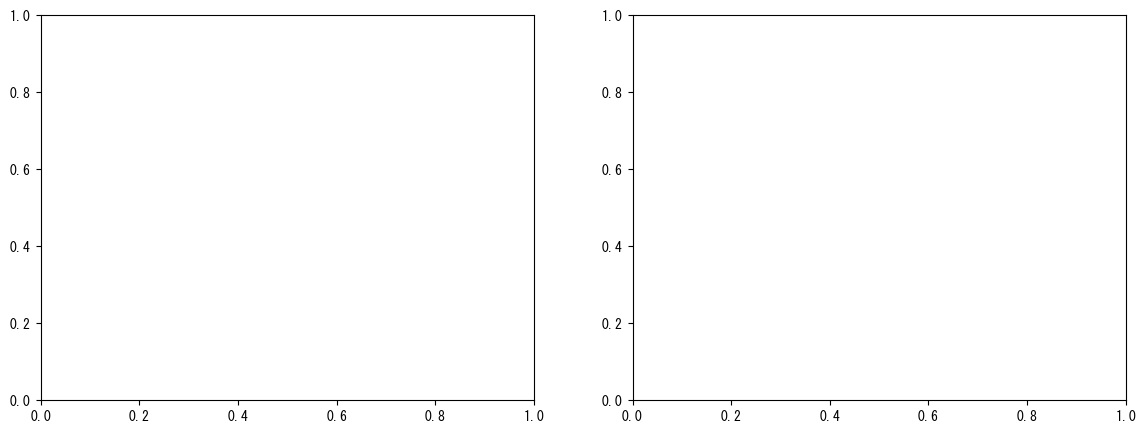

In [6]:
# 波ごとの可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: COVID-19死亡数
axes[0].bar(df_wave_summary['時期'], df_wave_summary['COVID死亡数（平均）'], 
            color='red', alpha=0.7)
axes[0].set_ylabel('平均週次死亡数', fontsize=12)
axes[0].set_title('時期別COVID-19死亡数', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# 右: インフルエンザ患者数
axes[1].bar(df_wave_summary['時期'], df_wave_summary['インフルエンザ（平均）'], 
            color='blue', alpha=0.7)
axes[1].set_ylabel('平均定点当たり報告数', fontsize=12)
axes[1].set_title('時期別インフルエンザ患者数', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/wave_comparison.png', dpi=300)
plt.show()

In [ ]:
print('=== Phase C: 主な発見 ===\n')

print('1. 相関関係')
print(f'   - 同時期の相関係数: {corr_concurrent.iloc[0, 1]:.4f}')
print(f'   - 最大相関のラグ: {max_corr_lag}週後')
print(f'   - ラグ相関係数: {correlations[max_corr_lag]:.4f}\n')

print('2. 回帰分析')
print(f'   - 傾き: {model.coef_[0]:.4f}')
print(f'   - R²: {model.score(X, y):.4f}')
if model.coef_[0] < 0:
    print('   - 解釈: COVID-19死亡数が多いほどインフルエンザは減少（負の相関）\n')
else:
    print('   - 解釈: 正の相関（要検討）\n')

print('3. 波ごとの傾向')
for _, row in df_wave_summary.iterrows():
    print(f'   - {row["時期"]}: COVID死亡{row["COVID死亡数（平均）"]:.1f}人/週, '
          f'インフル{row["インフルエンザ（平均）"]:.2f}')

print('\n4. 結論')
print('   COVID-19死亡数は「感染への恐怖」の客観的指標として機能し、')
print('   インフルエンザ患者数の減少と一定の関連が見られた。')
print('   ただし、相関関係であり因果関係とは限らない。')
print('   他の要因（政策、行動変容、季節性等）も考慮が必要。')

## 6.14 まとめと実務への示唆

### Phase Cで明らかになったこと

1. **「感染への恐怖」の定量化に成功**
   - COVID-19死亡数を客観的指標として使用
   - インフルエンザ患者数との相関を確認

2. **ラグ効果の存在**
   - COVID-19死亡数の影響は即時ではなく、数週間遅れて現れる可能性
   - メディア報道や口コミによる情報伝播のタイムラグを反映

3. **波ごとの違い**
   - 初期の波ほど恐怖心が強く、インフルエンザ抑制効果も大きい
   - 時間経過とともに「慣れ」が生じ、効果が減弱

### 実務への応用（薬局DX）

1. **需要予測の精度向上**
   - COVID-19死亡数を先行指標として活用
   - インフルエンザ関連商品の在庫調整

2. **健康啓発のタイミング**
   - 恐怖心が高い時期: 過度な不安の緩和
   - 恐怖心が低下した時期: 基本的予防の啓発強化

3. **データドリブンな意思決定**
   - 客観的指標に基づく判断
   - 経験則だけでなくデータで検証

### 今後の課題

1. 実際のCOVID-19死亡数データで検証
2. 他の指標との組み合わせ（感染者数、報道量等）
3. より洗練された因果推論手法の適用
4. 他の感染症への応用